In [52]:
import sys
import time
import dimod.utilities
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path

In [2]:
#job = "OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate

# jobs = [(0, 0, 0, 1, 0, 1), (1, 0, 0, 1, 0, 0.5), (1, 1, 0, 1, 0, 0.5)] # this job is more "complex" but at the cost of less steps tp saty under 1000 executions
jobs = [(0, 0, 0, 0, 0.5, 0.5), (1, 0, 0, 0, 0.5, 1)] # this job allows for more steps while staying under 1000 executions

steps = 1# steps = 5 for the first set, steps = 20 for the second

In [3]:
bend = [0, 1, 2]
weld = [3, 4]
paint =  [5]

bend_length = 2
weld_length = 3
paint_length = 6

t_step = 3 # necessary generalization
t_step_in_sec = 10

In [4]:
def max_time(jobs):
    a = 0 
    b = 0 
    c = 0
    for i in jobs:
        actualTime = i[2]
        if a < b and a < c:
            a += actualTime
        elif b < a and b < c:
            b += actualTime
        else:
            c += actualTime
    maxB = max(a, b, c) * bend_length
    
    a = 0
    b = 0
    for i in jobs:
        actualTime = i[3]
        if a < b:
            a += actualTime
        else:
            b += actualTime
    maxW = max(a, b) * weld_length
    
    maximumPainting = 0
    for i in jobs:
        maximumPainting += i[4]
    maxP = maximumPainting * paint_length
    
    return maxB + maxW + maxP

In [5]:
# OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate 

m_t_steps = max_time(jobs)

m_time = m_t_steps * t_step_in_sec
    
print('The maximal maketime for the given operations is: ' + str(m_time) + ' second(s).\nWhich is equal to: ' + str(m_t_steps) + ' time steps.\n\n')


The maximal maketime for the given operations is: 60.0 second(s).
Which is equal to: 6.0 time steps.




In [6]:
def ops(jobs, bend, weld, paint, m_time):
    ops = []
    for x in jobs:
        if x[2] > 0:
            punish = x[2] * bend_length
            if x[3] > 0:
                punish += x[3] * weld_length
            if x[4] > 0:
                punish += x[4] * paint_length
            for m in bend:
                t = 0
                while t <= m_t_steps - punish:
                    ops.append(tuple((x[0], x[1], x[2], m, t)))
                    t += t_step
                    
        if x[3] > 0:
            punish = x[3] * weld_length
            if x[4] > 0:
                punish += x[4] * paint_length
            for m in weld:
                t = 0
                if x[2] > 0:
                    t += x[2] * bend_length
                while t <= m_t_steps - punish:
                    ops.append(tuple((x[0], x[1], x[3], m, t)))
                    t += t_step

        if x[4] > 0:
            punish = x[4] * paint_length
            for m in paint:
                t = 0
                if x[2] > 0:
                    t += x[2] * bend_length
                if x[3] > 0:
                    t += x[3] * weld_length
                while t <= m_t_steps - punish:
                    ops.append(tuple((x[0], x[1], x[4], m, t)))
                    t += t_step
        # ops.append(('||||||||||||END OF JOB ' + str(x[0]) + ' OPERATION ' + str(x[1]) + '||||||||||||'))
    return ops

In [7]:
ops = ops(jobs, bend, weld, paint, m_time)

print('Number of combinations: ' + str(len(ops)) + '\n')

print('Possible combiniations:')
print('  Format: OrderNo, PartNo, Op, Machine, Time\n')

print(str(ops).replace('[(', '[\n(').replace(')]', ')\n]'))

Number of combinations: 4

Possible combiniations:
  Format: OrderNo, PartNo, Op, Machine, Time

[
(0, 0, 0.5, 5, 0), (0, 0, 0.5, 5, 3), (1, 0, 0.5, 5, 0), (1, 0, 0.5, 5, 3)
]


In [8]:
np.set_printoptions(threshold=sys.maxsize)
QUBO_X = np.zeros((len(ops), len(ops)))
np.set_printoptions(suppress=True)

In [9]:
# verwendet ops! --> als zusätzliches Argument?
def get_qubo_heatmap(QUBO, output="qubo_matrix.png"):
    
    df = pd.DataFrame(QUBO, columns=ops, index = ops)
    sns.set_style("white")
    mask = np.tril(np.zeros_like(df)).astype(np.bool)
    mask[np.tril_indices_from(mask)] = True

    # Keep diagonal elements 
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 12))

    # Generate a custom diverging colormap in TRUMPF Color 0033BA
    cmap = sns.diverging_palette(255, 200, sep=10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    # save to file
    fig = sns_plot.get_figure()
    fig.savefig(output)

In [10]:
# get_qubo_heatmap(QUBO_X)

In [11]:
def convert(ord, part, op, mach, t):
    return ops.index(tuple((ord, part, op, mach, t)))

In [12]:
#Format: OrderNo, PartNo, Op, Machine, Time 
    
def fill_QUBO_with_indexes(QUBO, ord1, part1, op1, mach1, t1, ord2, part2, op2, mach2, t2, value):
    index_a = convert(ord1, part1, op1, mach1, t1)
    index_b = convert(ord2, part2, op2, mach2, t2)
    if index_a > index_b:
        index_a, index_b = index_b, index_a
    QUBO[index_a, index_b] += value

Constraint 1 (each operation 'o' of each job 'j' exactly once on one machine 'm' at a certaint (starting-)time 't'):

$$
H_{0}:=\sum_{o \in 0}\left(\sum_{m \in M_{o}} \sum_{t=0}^{T-1} x_{j, o, m, t}-1\right)^{2}
$$


In [13]:
alpha = 2

In [14]:
# H0: Mehrmaliges Abarbeiten der selben Operation eines Bauteils eines Jobs bestrafen
'ops: OrderNo, PartNo, OpNum, Machine, Time'

for tupel1 in ops:
    for tupel2 in ops:
        if (tupel1[0] == tupel2[0]) and (tupel1[1] == tupel2[1]):
            if tupel1[3] != tupel2[3] or tupel1[4] != tupel2[4]:
                fill_QUBO_with_indexes(QUBO_X, *tupel1, *tupel2, 2*alpha)
            else:
                fill_QUBO_with_indexes(QUBO_X, *tupel1, *tupel2, -alpha)

In [15]:
# get_qubo_heatmap(QUBO_X)

Secondly, for every job $j \in J$, its operations $O_j$ must be executed in the order given by 

<br /><br />
$$
\left.c\right|_{o_{j}}: O_{j} \rightarrow\left\{1, \ldots, n_{j}\right\}
$$
<br />
$$H_{1}:=\sum_{j \in J}\left(\sum_{k_{n-1}<i<k_{n}, t+p_{i} > t'} x_{i, t}x_{i+1, t'}\right)$$


In [16]:
beta = 1

In [17]:
# H1 verbotene Reihenfolgen innerhalb eines Bauteils eines Jobs bestrafen
'ops: OrderNo, PartNo, OpNum, Machine, Time'

for tupel1 in ops:
    if tupel1[3] < min(paint):
        if tupel1[3] < min(weld):
            dom = bend_length * tupel1[2]
        else:
            dom = weld_length * tupel1[2]
        for tupel2 in ops:
            if (tupel1[0] == tupel2[0]) and (tupel1[1] == tupel2[1]):
                if (tupel1[3] <= max(bend) and tupel2[3] > max(bend) and (tupel1[4] + dom) > tupel2[4] or tupel1[3] > max(bend) and tupel1[3] < min(paint) and tupel2[3] >= min(paint) and (tupel1[4] + dom) > tupel2[4]):
                    fill_QUBO_with_indexes(QUBO_X, *tupel1, *tupel2, beta)

In [18]:
# get_qubo_heatmap(QUBO_X)

In [19]:
gamma = 2

In [20]:
# H2 Geichzeitiges Laufen zweier verschiedener Operationen auf der selben M
'ops: OrderNo, PartNo, OpNum, Machine, Time'

for tupel1 in ops:
    if tupel1[3] < min(weld):
        dom = bend_length * tupel1[2]
    elif tupel1[3] < min(paint):
        dom = weld_length * tupel1[2]
    else:
        dom = paint_length * tupel1[2]
    for tupel2 in ops:
        if ((tupel1[0] != tupel2[0] or tupel1[1] != tupel2[1]) and tupel1[3] == tupel2[3] and tupel2[4] >= tupel1[4] and tupel2[4] < tupel1[4] + dom):
            fill_QUBO_with_indexes(QUBO_X, *tupel1, *tupel2, gamma)

In [21]:
# get_qubo_heatmap(QUBO_X) 

In [22]:
delta = 0.035

In [23]:
# K Bestrafung für Verspätung
'ops: OrderNo, PartNo, OpNum, Machine, Time'
'jobs: OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate'
     
c = 0
while c < len(jobs):
    t1 = 0
    while t1 < len(ops):
        if jobs[c][0] == ops[t1][0]:
            tail = 0
            if ops[t1][3] < min(weld): # op is bend
                dom = bend_length * ops[t1][2]
                if jobs[c][3] > 0: # has weld op
                    tail += jobs[c][3] * weld_length
                if jobs[c][4] > 0: # has paint op
                    tail += jobs[c][4] * paint_length
            elif ops[t1][3] < min(paint): # op is weld
                dom = weld_length * ops[t1][2]
                if jobs[c][4] > 0: # has paint op
                    tail += jobs[c][4] * paint_length
            else:
                dom = paint_length * ops[t1][2]
            if ops[t1][4] + dom + tail > jobs[c][5] * 6:
                fill_QUBO_with_indexes(QUBO_X, *ops[t1], *ops[t1], delta)
            # else:
                # fill_QUBO_with_indexes(QUBO, *ops[t1], *ops[t1], -delta)
        t1 += 1
    c += 1

<ipython-input-9-ccafbb0ddcf9>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.tril(np.zeros_like(df)).astype(np.bool)


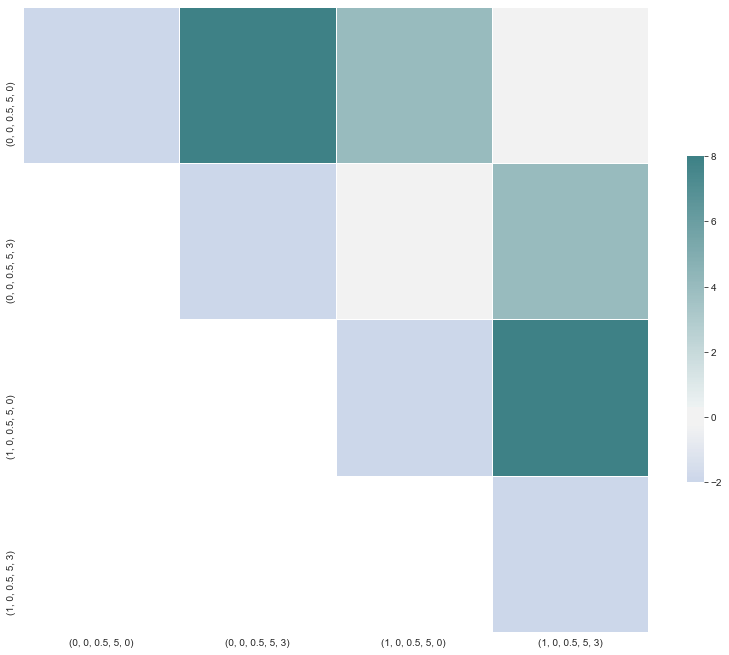

In [24]:
get_qubo_heatmap(QUBO_X) 

In [25]:
def simplify_qubo(qubo):
    qi = 0
    while qi < len(ops):
      qj = qi
      while qj < len(ops):
          if qubo[qi, qj] >= -1 and qubo[qi, qj] <= 1:
              qubo[qi, qj] -= np.int64(4)
          qj += 1
      qi += 1

In [26]:
# QUBO_X = simplify_qubo(QUBO_X)

In [27]:
# get_qubo_heatmap(QUBO_X) 

In [28]:
qubo_d = {}
x1 = 0
while x1 < len(ops):
    x2 = x1
    while x2 < len(ops):
        qubo_d[(x1, x2)] = int(QUBO_X[x1][x2])
        x2 += 1
    x1 += 1
    
print(qubo_d)

{(0, 0): -2, (0, 1): 8, (0, 2): 4, (0, 3): 0, (1, 1): -1, (1, 2): 0, (1, 3): 4, (2, 2): -2, (2, 3): 8, (3, 3): -2}


In [29]:
# solve and print first result
result = QBSolv().sample_qubo(qubo_d)
print(result)
result = [result.samples()[0][x] for x in result.samples()[0]]
schedule = []
for i in range(len(result)):
    if result[i] == 1:
        schedule.append(ops[i])
df_schedule=pd.DataFrame(schedule)
df_schedule.columns = ["OrderNo", "PartNo", "Op", "Task", "Time"]

   0  1  2  3 energy num_oc.
0  1  0  0  1   -4.0      51
['BINARY', 1 rows, 51 samples, 4 variables]


In [30]:
def make_symmetric(matrix):
    """ Takes a quadratic matrix and makes it symmetric """
    result = copy.deepcopy(matrix) # technically unnecessary
    for i in range(len(result)):
        for j in range(len(result[i])):
            if(i != j):
                if (result[i][j] != 0):
                    if (result[j][i] == 0):
                        result[j][i] = result[i][j] / 2
                        result[i][j] = result[j][i]
    return result
q_QUBO_X = make_symmetric(QUBO_X)

In [31]:
isingX = dimod.qubo_to_ising(qubo_d, 0)
print(isingX)
(linear, quadratic, _) = isingX
print("\n")
print(linear)
print("\n")
print(quadratic)

({0: 2.0, 1: 2.5, 2: 2.0, 3: 2.0}, {(0, 1): 2.0, (0, 2): 1.0, (1, 3): 1.0, (2, 3): 2.0}, 2.5)


{0: 2.0, 1: 2.5, 2: 2.0, 3: 2.0}


{(0, 1): 2.0, (0, 2): 1.0, (1, 3): 1.0, (2, 3): 2.0}


In [32]:
n_qubits = len(ops)
wires = range(n_qubits)
depthX = 2

In [33]:
s3 = ("amazon-braket-1a7ac1e84178", "TRUMPF")
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
dev = qml.device("braket.aws.qubit", device_arn=device_arn, s3_destination_folder=s3, wires=wires, parallel=True, max_parallel=20, poll_timeout_seconds=30, shots=1000)

In [34]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
linear_gates = [qml.PauliZ(i) for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]
quadratic_gates = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(n_qubits) for j in range(n_qubits) if
                       (i, j) in quadratic]

coefficents = linear_coefficents + quadratic_coefficents
gates = linear_gates + quadratic_gates

cost_h = qml.Hamiltonian(coefficents, gates)
print(cost_h)

  (2.0) [Z0]
+ (2.0) [Z2]
+ (2.0) [Z3]
+ (2.5) [Z1]
+ (1.0) [Z0 Z2]
+ (1.0) [Z1 Z3]
+ (2.0) [Z0 Z1]
+ (2.0) [Z2 Z3]


In [35]:
mixer_h = qaoa.x_mixer(0)
for i in range(n_qubits - 1):
    mixer_h += qaoa.x_mixer(i + 1)
print(mixer_h)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [36]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [37]:
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depthX, params[0], params[1])

In [38]:
cost_function = qml.ExpvalCost(circuit, cost_h, dev, optimize=True)

In [39]:
optimizer = qml.AdamOptimizer() # qml.GradientDescentOptimizer() # qml.AdamOptimizer() # qml.AdagradOptimizer()
params = [[0.5, 0.5], [0.5, 0.5]]

In [40]:
print("Start parameters: ", params)
print("\n")

for i in progressbar.progressbar(range(steps), redirect_stdout=True):
    params = optimizer.step(cost_function, params)
    print(' | New parameters:', params)
    print("\n", dev.num_executions)

print("\n")
print("Optimal parameters: ", params)

Start parameters:  [[0.5, 0.5], [0.5, 0.5]]




N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

 | New parameters: [[0.5099999999918261, 0.4900000000136342], [0.4900000000902527, 0.5099999999694284]]


N/A% (0 of 1) |                          | Elapsed Time: 0:00:24 ETA:  --:--:--


 0


100% (1 of 1) |##########################| Elapsed Time: 0:00:24 Time:  0:00:24




Optimal parameters:  [[0.5099999999918261, 0.4900000000136342], [0.4900000000902527, 0.5099999999694284]]


In [45]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

C:\Users\vd5t\Desktop\QCP\0 QGM\notebooks
C:\Users\vd5t\Desktop\QCP\0 QGM\notebooksAdamOptimizer_2_1_[[0.5099999999918261, 0.4900000000136342], [0.4900000000902527, 0.5099999999694284]]


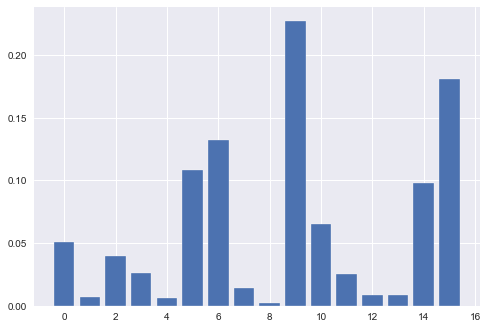

In [58]:
optimizerType = type(optimizer).__name__
path = os.getcwd()
print(path)
savestring = path + f"{optimizerType}_{depthX}_{steps}_{params}"
print(savestring)

plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig(savestring + ".png")
plt.show()

In [44]:
file = open(savestring + ".txt", 'w')
file.write(str(probs)
    # + "\n model variables: " + str(model.variables)
    + "\n optimizer: " + optimizerType
    # + "\n optimizer time: " + str(processing_time_optimizer)
    # + "\n qc time: " + str(processing_time_qc)
    + "\n backend: " + str(dev))
file.close()

In [ ]:
whos